In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

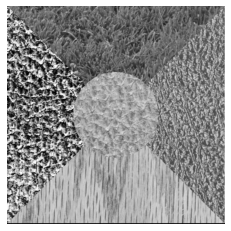

In [2]:
image = cv2.imread('image.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

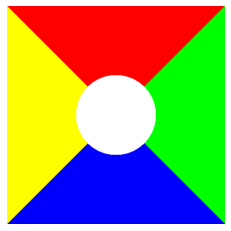

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Create an image with three color channels (RGB)
mask = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)

# Define the square's parameters
x, y = 0, 0
size = image.shape[0]

# Draw the square
cv2.rectangle(mask, (x, y), (x + size, y + size), (255, 255, 255), 2)

# Calculate the coordinates for the triangle vertices
x_mid = x + size // 2
y_mid = y + size // 2

# Draw the triangles
triangle1 = np.array([[x, y], [x + size, y], [x_mid, y_mid]])
triangle2 = np.array([[x + size, y], [x + size, y + size], [x_mid, y_mid]])
triangle3 = np.array([[x, y + size], [x + size, y + size], [x_mid, y_mid]])
triangle4 = np.array([[x, y], [x, y + size], [x_mid, y_mid]])

# Draw the triangles on the mask with different colors
cv2.fillPoly(mask, [triangle1], (255, 0, 0))
cv2.fillPoly(mask, [triangle2], (0, 255, 0))
cv2.fillPoly(mask, [triangle3], (0, 0, 255))
cv2.fillPoly(mask, [triangle4], (255, 255, 0))

# Draw a white circle with a desired radius and center
radius = 90
cv2.circle(mask, (x_mid, y_mid), radius, (255, 255, 255), -1)

# Display the mask using matplotlib
plt.imshow(mask)
plt.axis('off')
plt.show()

In [4]:
image.shape, mask.shape

((491, 491), (491, 491, 3))

In [5]:
cv2.imwrite("mask.jpg", cv2.cvtColor(mask, cv2.COLOR_RGB2BGR))

True

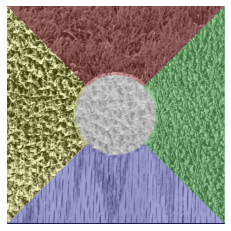

In [6]:
blended = cv2.addWeighted(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB), 0.8, mask , 0.2, 0)
plt.imshow(blended)
plt.axis('off')
plt.show()

In [7]:
def break_image_into_sub_images(image, mask, rows, cols):
    # Get the size of each smaller image
    height, width = image.shape[0:2]
    sub_image_height = height // rows
    sub_image_width = width // cols

    # Store the smaller sub_images and sub_masks in lists
    sub_images = []
    sub_masks = []
    for row in range(rows):
        for col in range(cols):
            # Extract a small section from the image
            y_start = row * sub_image_height
            y_end = y_start + sub_image_height
            x_start = col * sub_image_width
            x_end = x_start + sub_image_width
            sub_image = image[y_start:y_end, x_start:x_end]
            sub_mask = mask[y_start:y_end, x_start:x_end, :]
            sub_images.append(sub_image)
            sub_masks.append(sub_mask)

    return sub_images, sub_masks

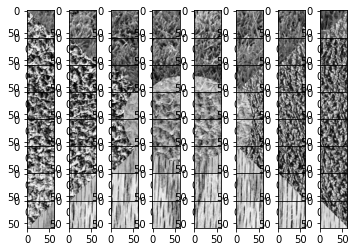

In [8]:
rows = 8
cols = 8

sub_images, sub_masks = break_image_into_sub_images(image, mask, rows, cols)
images = []
masks = []
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0, wspace=0)
for i, sub_image in enumerate(sub_images):
    ax = axs[i // cols, i % cols]
    ax.imshow(sub_image, cmap='gray')
    images.append(sub_image)
    masks.append(sub_masks[i])

images = np.array(images)
masks = np.array(masks)
plt.show()

In [9]:
# Original shapes
print("Original image shape:", images.shape)
print("Original mask shape:", masks.shape)

# Drop a pixel if dimensions are odd
images = images[:, :images.shape[1] // 2 * 2, :images.shape[2] // 2 * 2]
masks = masks[:, :masks.shape[1] // 2 * 2, :masks.shape[2] // 2 * 2, :]

# New shapes
print("New image shape:", images.shape)
print("New mask shape:", masks.shape)

Original image shape: (64, 61, 61)
Original mask shape: (64, 61, 61, 3)
New image shape: (64, 60, 60)
New mask shape: (64, 60, 60, 3)


In [10]:
INPUT_HEIGHT = images.shape[1]
INPUT_WIDTH = images.shape[2]

In [11]:
images.shape, masks.shape

((64, 60, 60), (64, 60, 60, 3))

In [12]:
color_labels = ['blue', 'green', 'red', 'yellow', 'white']

def get_labels(images, masks):
    labels = np.zeros(images.shape[0])
    
    # Iterate through each mask image
    for i, mask in enumerate(masks):
        pixel_counts = {label: 0 for label in color_labels}
        
        white_pixels = np.all(mask == [255, 255, 255], axis=-1)
        count = np.sum(white_pixels)
        pixel_counts['white'] = count

        yellow_pixels = np.all(mask == [255, 255, 0], axis=-1)
        count = np.sum(yellow_pixels)
        pixel_counts['yellow'] = count

        red_pixels = np.all(mask == [255, 0, 0], axis=-1)
        count = np.sum(red_pixels)
        pixel_counts['red'] = count

        green_pixels = np.all(mask == [0, 255, 0], axis=-1)
        count = np.sum(green_pixels)
        pixel_counts['green'] = count

        blue_pixels = np.all(mask == [0, 0, 255], axis=-1)
        count = np.sum(blue_pixels)
        pixel_counts['blue'] = count
        
        # Determine the label with the maximum pixel count
        max_label = max(pixel_counts, key=pixel_counts.get)
        
        # Assign the label value based on the color
        if max_label == 'white':
            labels[i] = 0
        elif max_label == 'yellow':
            labels[i] = 1
        elif max_label == 'red':
            labels[i] = 2
        elif max_label == 'green':
            labels[i] = 3
        elif max_label == 'blue':
            labels[i] = 4
    labels = labels.astype('uint8')
    return labels

In [13]:
labels = get_labels(images, masks)

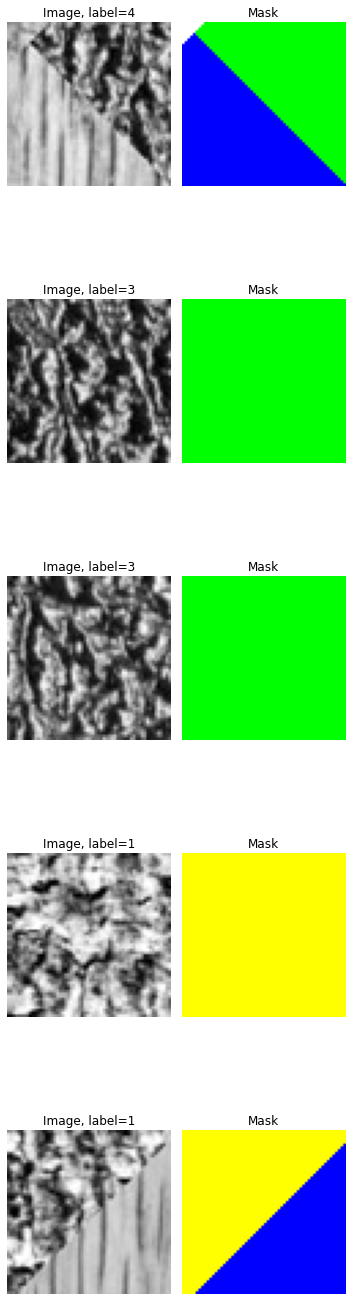

In [14]:
def plot_images_masks(images, masks, labels=None):
    num_samples = images.shape[0]

    fig, axs = plt.subplots(num_samples, 2, figsize=(5, 20))

    for i in range(num_samples):
        axs[i, 0].imshow(images[i], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title(f'Image{", label="+ str(labels[i]) if labels is not None else ""}')

        axs[i, 1].imshow(masks[i], cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()
plot_images_masks(images[45:50], masks[45:50], labels[45:50])

In [15]:
import numpy as np
from sklearn.model_selection import train_test_split

test_size = 0.2
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=test_size, random_state=42)
train_labels = get_labels(train_images, train_masks)
test_labels = get_labels(test_images, test_masks)

print("Train set shapes: ", train_images.shape, train_masks.shape)
print("Test set shapes: ", test_images.shape, test_masks.shape)

Train set shapes:  (51, 60, 60) (51, 60, 60, 3)
Test set shapes:  (13, 60, 60) (13, 60, 60, 3)


In [16]:
import imgaug.augmenters as iaa

augmentation_seq = iaa.Sequential([
    iaa.Flipud(0.5),             # Flip images vertically
    iaa.Affine(rotate=(-10, 10)), # Rotate images within the range -10 to 10 degrees
    iaa.GaussianBlur(sigma=(0, 1.0)),  # Apply Gaussian blur with sigma between 0 and 1.0
])

augmented_train_images = []
augmented_train_labels = []

augmentation_factor = 4

for _ in range(augmentation_factor):
    augmented_data = augmentation_seq.augment(images=train_images)
    augmented_train_images.extend(augmented_data)
    augmented_train_labels.extend(train_labels)

# Convert the augmented data to NumPy arrays
augmented_train_images = np.array(augmented_train_images)
augmented_train_labels = np.array(augmented_train_labels)

print("Augmented images shape: ", augmented_train_images.shape)
print("Augmented labels shape: ", augmented_train_labels.shape)

Augmented images shape:  (204, 60, 60)
Augmented labels shape:  (204,)


In [17]:
augmented_train_images = augmented_train_images / 255.0
test_images = test_images /255.0

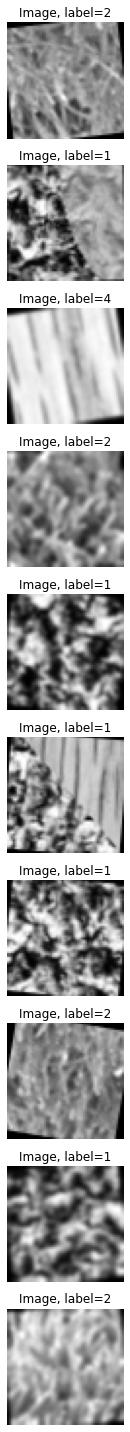

In [18]:
def plot_augmented_images_labels(images, labels):
    num_samples = images.shape[0]

    fig, axs = plt.subplots(num_samples, 1, figsize=(5, 20))

    for i in range(num_samples):
        axs[i].imshow(images[i], cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f'Image{", label="+ str(labels[i]) if labels is not None else ""}')


    plt.tight_layout()
    plt.show()
plot_augmented_images_labels(augmented_train_images[:10], augmented_train_labels[:10])

In [19]:
# Reshape augmented labels to include the channel dimension
augmented_train_labels = np.expand_dims(augmented_train_labels, axis=1)
augmented_train_images.shape, augmented_train_labels.shape

((204, 60, 60), (204, 1))

In [20]:
from tensorflow import keras
from tensorflow.keras import layers

# Define the input shape
input_shape = (60, 60, 1)

# Define the number of classes
num_classes = 5

# Create the CNN model
model = keras.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 58, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 29, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 10816)             0         
                                                                 
 dense (Dense)               (None, 128)               1

In [21]:
augmented_train_images.shape

(204, 60, 60)

In [22]:
# Define the number of epochs and batch size
epochs = 25
batch_size = 32

# Fit the model to the training data
history = model.fit(augmented_train_images, augmented_train_labels, batch_size=batch_size, epochs=epochs, verbose=1)

Epoch 1/25
7/7 [==============================] - 1s 68ms/step - loss: 1.5342 - accuracy: 0.2451
Epoch 2/25
7/7 [==============================] - 0s 66ms/step - loss: 1.3183 - accuracy: 0.4853
Epoch 3/25
7/7 [==============================] - 1s 98ms/step - loss: 1.0989 - accuracy: 0.6176
Epoch 4/25
7/7 [==============================] - 1s 107ms/step - loss: 0.9585 - accuracy: 0.6176
Epoch 5/25
7/7 [==============================] - 1s 115ms/step - loss: 0.8464 - accuracy: 0.6912
Epoch 6/25
7/7 [==============================] - 1s 109ms/step - loss: 0.7140 - accuracy: 0.8137
Epoch 7/25
7/7 [==============================] - 0s 63ms/step - loss: 0.5961 - accuracy: 0.8039
Epoch 8/25
7/7 [==============================] - 0s 64ms/step - loss: 0.5058 - accuracy: 0.8088
Epoch 9/25
7/7 [==============================] - 1s 71ms/step - loss: 0.4455 - accuracy: 0.8431
Epoch 10/25
7/7 [==============================] - 1s 72ms/step - loss: 0.4637 - accuracy: 0.8284
Epoch 11/25
7/7 [=========

In [23]:
model.save('model.h5')

In [24]:
loss, accuracy = model.evaluate(test_images, test_labels)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

1/1 [==============================] - 0s 197ms/step - loss: 0.4538 - accuracy: 0.7692
Test Loss: 0.45382851362228394
Test Accuracy: 0.7692307829856873


In [25]:
predicted_test_labels = model.predict(test_images)

1/1 [==============================] - 0s 113ms/step


In [26]:
predicted_classes = np.argmax(predicted_test_labels, axis=1).astype(np.uint8)
predicted_classes 

array([0, 4, 1, 0, 2, 2, 1, 2, 1, 4, 1, 1, 1], dtype=uint8)

In [27]:
true_classes = get_labels(test_images, test_masks)
true_classes

array([4, 4, 1, 4, 2, 0, 1, 2, 1, 4, 1, 1, 1], dtype=uint8)

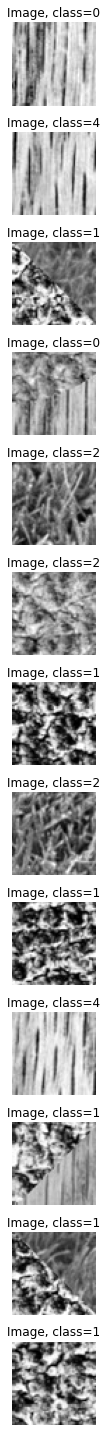

In [28]:
num_samples = test_images.shape[0]

fig, axs = plt.subplots(num_samples, 1, figsize=(5, 20))

for i in range(num_samples):
    axs[i].imshow(test_images[i], cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f'Image, class={predicted_classes[i]}')


plt.tight_layout()
plt.show()

In [29]:
accuracy = np.mean(true_classes == predicted_classes)

# Print the accuracy
print("Accuracy:", accuracy)

Accuracy: 0.7692307692307693


In [30]:
true_classes

array([4, 4, 1, 4, 2, 0, 1, 2, 1, 4, 1, 1, 1], dtype=uint8)